In [1]:
%matplotlib inline


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import timeit
import time 

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%%time

train_df = pd.read_csv('train.csv', header=0)

CPU times: user 4.69 s, sys: 952 ms, total: 5.64 s
Wall time: 6.37 s


In [3]:
y = train_df['label']
X = train_df.copy().drop('label', axis=1)
X_scaled = scale(X)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

## Nearest Centroid Classifier 

In [53]:
%%time

from sklearn.neighbors.nearest_centroid import NearestCentroid

nearest_centroid_clf = NearestCentroid()
nearest_centroid_clf.fit(X_train, y_train)

CPU times: user 331 ms, sys: 38 ms, total: 369 ms
Wall time: 372 ms


In [54]:
%%time

y_pred = nearest_centroid_clf.predict(X_test)

CPU times: user 129 ms, sys: 7.96 ms, total: 137 ms
Wall time: 69.2 ms


In [55]:
accuracy_score(y_test,y_pred, normalize=True)

0.80202020202020197

In [68]:
nearest_centroid_clf.get_params()

{'metric': 'euclidean', 'shrink_threshold': None}

## KNN Classifier 

In [5]:
%%time

from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=3)

CPU times: user 7.97 ms, sys: 15.4 ms, total: 23.3 ms
Wall time: 37.6 ms


In [6]:
%%time
knn_clf.fit(X_train, y_train) 

# >>> print(neigh.predict([[1.1]]))
# [0]
# >>> print(neigh.predict_proba([[0.9]]))
# [[ 0.66666667  0.33333333]]

CPU times: user 11.5 s, sys: 163 ms, total: 11.7 s
Wall time: 11.9 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [7]:
%%time
y_pred2 = knn_clf.predict(X_test)

CPU times: user 7min 15s, sys: 1.08 s, total: 7min 17s
Wall time: 7min 18s


In [8]:
accuracy_score(y_test,y_pred2, normalize=True)

0.93694083694083696

In [9]:
y_check_knn = y_pred2 == y_test

y_check_knn = y_check_knn.reset_index()

y_check_knn = y_check_knn.drop('index', 1)

In [10]:
# knn_clf.get_params()

## Random Forest 

* Scikit learn decision trees will turn numeric predictor variables into binary variables by binning them optimally
* The decision tree is then created by placing binary predictors with most information gain at the top

In [11]:
%%time

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)

CPU times: user 46.1 ms, sys: 58.5 ms, total: 105 ms
Wall time: 178 ms


In [12]:
%%time

rf_clf = clf.fit(X_train, y_train)

CPU times: user 23.3 s, sys: 248 ms, total: 23.6 s
Wall time: 23.6 s


In [13]:
y_pred3 = rf_clf.predict(X_test)

In [14]:
y_prob = rf_clf.predict_proba(X_test)

In [15]:
y_prob_df = pd.DataFrame(y_prob)

y_prob_max = y_prob_df.apply(np.max, axis=1)

y_prob_max_df = pd.DataFrame(data={'Vote_Freq':y_prob_max})

In [16]:
y_check_rf = y_pred3 == y_test

y_check_rf = y_check_rf.reset_index()

y_check_rf = y_check_rf.drop('index', 1)

In [17]:
y_check_rf_df = pd.DataFrame(data={"is_correct" : y_check_rf['label'], "vote_frequency":y_prob_max_df['Vote_Freq']})

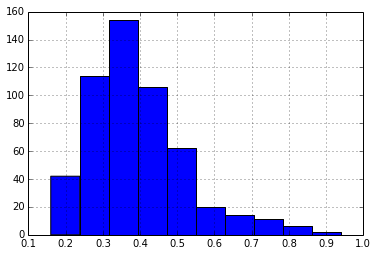

In [31]:
#only incorrect outputs
y_check_rf_df[y_check_rf_df['is_correct'] == False]['vote_frequency'].hist()

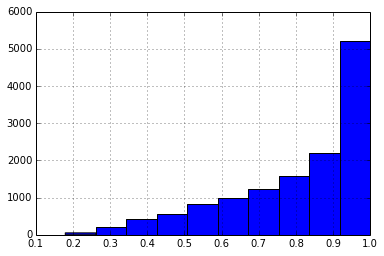

In [38]:
#only correct outputs
y_check_rf_df[y_check_rf_df['is_correct'] == True]['vote_frequency'].hist()

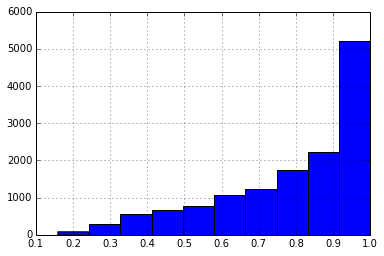

In [37]:
y_check_rf_df['vote_frequency'].hist()

In [55]:
less_than_31 = y_check_rf_df[y_check_rf_df['vote_frequency'] < .31]

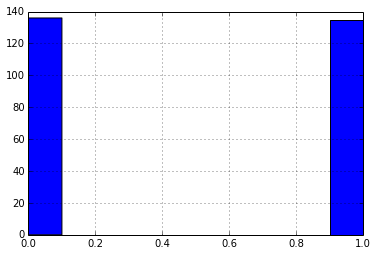

In [56]:
less_than_31['is_correct'].hist()

In [1]:
# y_check_rf_df

In [19]:
accuracy_score(y_test,y_pred3, normalize=True)

0.9616883116883117

### We will tune random forest later with gridsearch

In [81]:
# rf_clf.get_params()

## Do the different classifiers fail similarly? 

In [104]:
# y_check_rf_df[y_check_rf_df['is_correct'] == False]

# y_test

#series that shows knn results
knn_results = y_pred2 == y_test

#series that shows rf results
rf_results = y_pred3 == y_test

clf_results_df = pd.DataFrame(data={'knn_results':knn_results, 'rf_results': rf_results})

In [113]:
clf_results_df[clf_results_df['rf_results'] == False].describe()

,knn_results,rf_results
count,522,522
mean,0.4597701,0
std,0.498857,0
min,False,False
25%,0,0
50%,0,0
75%,1,0
max,True,False


In [117]:
y_prob_rf = y_prob_max_df.set_index(clf_results_df.index)

In [118]:
clf_results_df['rf_freq'] = y_prob_rf = y_prob_max_df.set_index(clf_results_df.index)

In [120]:
# clf_results_df

In [122]:
rf_incorrect = clf_results_df[clf_results_df['rf_results'] == False]

In [125]:
# .5 is arbitrary

rf_incorrect[rf_incorrect['rf_freq'] < .5].describe()

,knn_results,rf_results,rf_freq
count,431,431,431.000000
mean,0.487239,0,0.351531
std,0.500418,0,0.076051
min,False,False,0.160000
25%,0,0,0.290000
50%,0,0,0.360000
75%,1,0,0.410000
max,True,False,0.490000
